## Imports

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

## Read CSV

In [27]:
# Read csv
data = pd.read_csv('online_pre_processing.csv')
print("Shape: " + str(data.shape))

Shape: (13709, 24)


In [28]:
data.dtypes

datetime                       object
source                         object
face                            int64
face_bbox_x1                    int64
face_bbox_y1                    int64
face_bbox_x2                    int64
face_bbox_y2                    int64
head_yaw                      float64
head_pitch                    float64
head_roll                     float64
left_eye_state                 object
right_eye_state                object
left_eye_state_confidence     float64
right_eye_state_confidence    float64
gaze_yaw                      float64
gaze_pitch                    float64
facial_expression              object
race                           object
gender                         object
age                             int64
face_center_x                 float64
face_center_y                 float64
face_area                       int64
person                          int64
dtype: object

## Gaze and Head Positions Adjusts

In [29]:
timeBlock = 5
time_adjust = '5s'

In [30]:


data['datetime'] = pd.to_datetime(data['datetime'])
data['time_block'] = (data['datetime'] - data['datetime'].min()).dt.total_seconds() // (60 * timeBlock)
persons = data['person'].unique()

for person in persons:
    mask_person = data['person'] == person
    
    
    for block in data.loc[mask_person, 'time_block'].unique():
        mask_block = (data['time_block'] == block) & mask_person # Intersection between person and block
        data_person_block = data[mask_block]
        
        data.loc[mask_block, 'gaze_pitch_mean'] = data_person_block['gaze_pitch'].mean()
        data.loc[mask_block, 'gaze_yaw_mean'] = data_person_block['gaze_yaw'].mean()
        data.loc[mask_block, 'head_pitch_mean'] = data_person_block['head_pitch'].mean()
        data.loc[mask_block, 'head_yaw_mean'] = data_person_block['head_yaw'].mean()
        data.loc[mask_block, 'head_roll_mean'] = data_person_block['head_roll'].mean()

In [31]:
data.set_index('datetime', inplace=True)
result = []

for (person, time_block), group in data.groupby(['person', 'time_block']):

    group['gaze_pitch_adjusted'] = group['gaze_pitch'].resample(time_adjust).transform('mean') - group['gaze_pitch_mean'].iloc[0]
    group['gaze_yaw_adjusted'] = group['gaze_yaw'].resample(time_adjust).transform('mean') - group['gaze_yaw_mean'].iloc[0]
    group['head_pitch_adjusted'] = group['head_pitch'].resample(time_adjust).transform('mean') - group['head_pitch_mean'].iloc[0]
    group['head_yaw_adjusted'] = group['head_yaw'].resample(time_adjust).transform('mean') - group['head_yaw_mean'].iloc[0]
    group['head_roll_adjusted'] = group['head_roll'].resample(time_adjust).transform('mean') - group['head_roll_mean'].iloc[0]
    
    result.append(group)

data = pd.concat(result).sort_index()
data.reset_index(inplace=True)

### Check Data

In [32]:
# Check the data
print("_________________________")
print(f"Size Block: {timeBlock} minutes")
print(data['time_block'].value_counts())
print("_________________________")

print("Duration:")
print(str((data['datetime'].max() - data['datetime'].min()).seconds / 60) + " minutes")
print("_________________________")


persons = data['person'].unique()

for person in persons:
    print(f"Person: {person}")
    data_person = data[data['person'] == person]
    print(f"Head Yaw values: {data_person['head_yaw_mean'].unique()}")
    print(f"Head Pitch values: {data_person['head_pitch_mean'].unique()}")
    print(f"Head Roll values: {data_person['head_roll_mean'].unique()}")
    print(f"Gaze Yaw values: {data_person['gaze_yaw_mean'].unique()}")
    print(f"Gaze Pitch values: {data_person['gaze_pitch_mean'].unique()}")
    print("_________________________")

_________________________
Size Block: 5 minutes
time_block
0.0    6528
1.0    4753
2.0    2428
Name: count, dtype: int64
_________________________
Duration:
12.55 minutes
_________________________
Person: 0
Head Yaw values: [-25.35096734  -0.98773187 -31.74975265]
Head Pitch values: [13.82081658  5.49613828 13.88289753]
Head Roll values: [-1.11534548 -5.57383642 -6.53897527]
Gaze Yaw values: [-18.35938442  -2.27221754 -23.50263251]
Gaze Pitch values: [ 3.34868719 -2.68721754 -1.21561837]
_________________________
Person: 2
Head Yaw values: [18.64734101  8.93794786  8.05042994]
Head Pitch values: [ 5.36726227 -7.64944491 -5.11323248]
Head Roll values: [ 1.63020594  4.15349874 -0.29095541]
Gaze Yaw values: [20.62276802  9.92045416  6.08378981]
Gaze Pitch values: [ 0.22107813 -3.7441127  -2.81780255]
_________________________
Person: 3
Head Yaw values: [1.353961  4.6814899 6.5682658]
Head Pitch values: [25.75579525 23.57818182 24.78779579]
Head Roll values: [-0.73295551 -0.24797138  1.090

In [33]:

print("#######################")
print(f"Adjusted value: {time_adjust}")
print(f"Block size: {timeBlock} minutes")
print("#######################")
print("_________________________")

for person in persons:
    person_data = data[data['person'] == person]
    print(f"Person: {person}")
    print((person_data['head_yaw_adjusted'].describe()).astype(int))        # Head Yaw
    # print((person_data['head_pitch_adjusted'].describe()))      # Head Pitch
    # print((person_data['head_roll_adjusted'].describe()).astype(int))       # Head Roll
    # print((person_data['gaze_yaw_adjusted'].describe()).astype(int))   # Gaze Yaw
    # print((person_data['gaze_pitch_adjusted'].describe()).astype(int))      # Gaze Pitch
    print("_________________________")    

#######################
Adjusted value: 5s
Block size: 5 minutes
#######################
_________________________
Person: 0
count    3344
mean        0
std        13
min       -30
25%       -11
50%         0
75%         7
max        28
Name: head_yaw_adjusted, dtype: int32
_________________________
Person: 2
count    3468
mean        0
std        11
min       -26
25%        -8
50%         1
75%         9
max        25
Name: head_yaw_adjusted, dtype: int32
_________________________
Person: 3
count    3446
mean        0
std         4
min        -9
25%        -3
50%         0
75%         2
max        15
Name: head_yaw_adjusted, dtype: int32
_________________________
Person: 1
count    3451
mean        0
std         4
min       -16
25%        -3
50%         0
75%         2
max        18
Name: head_yaw_adjusted, dtype: int32
_________________________


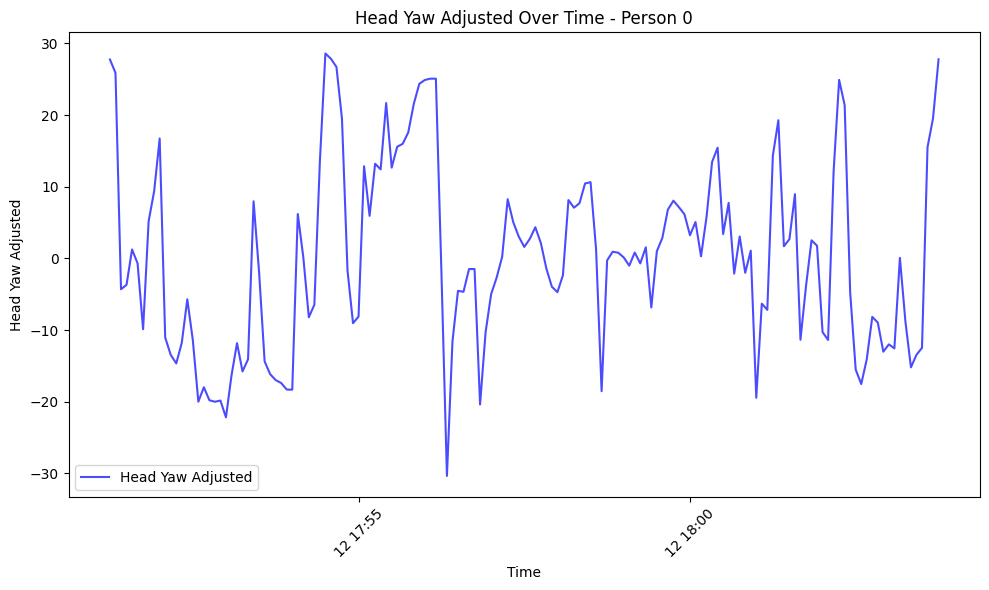

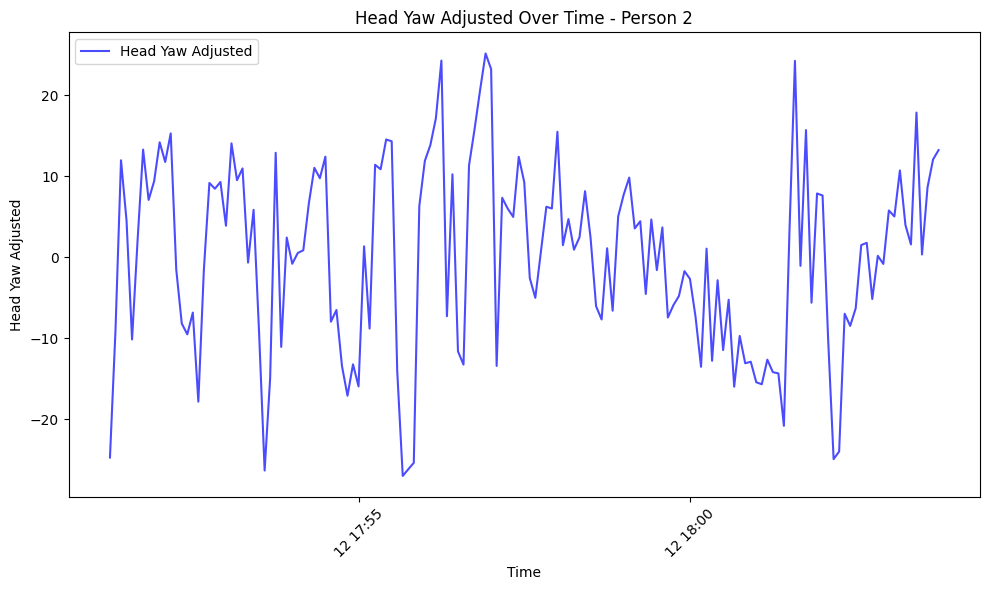

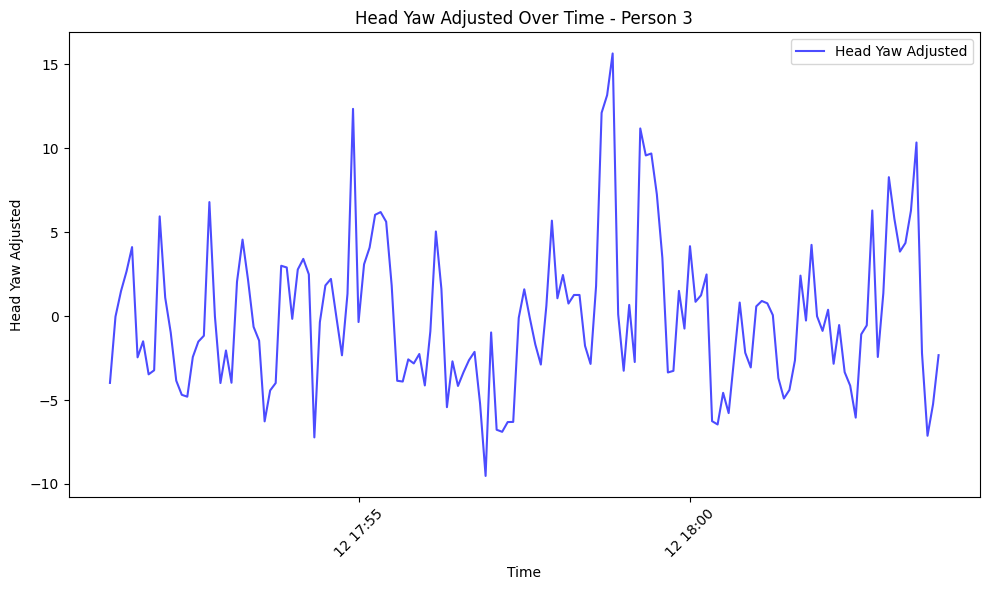

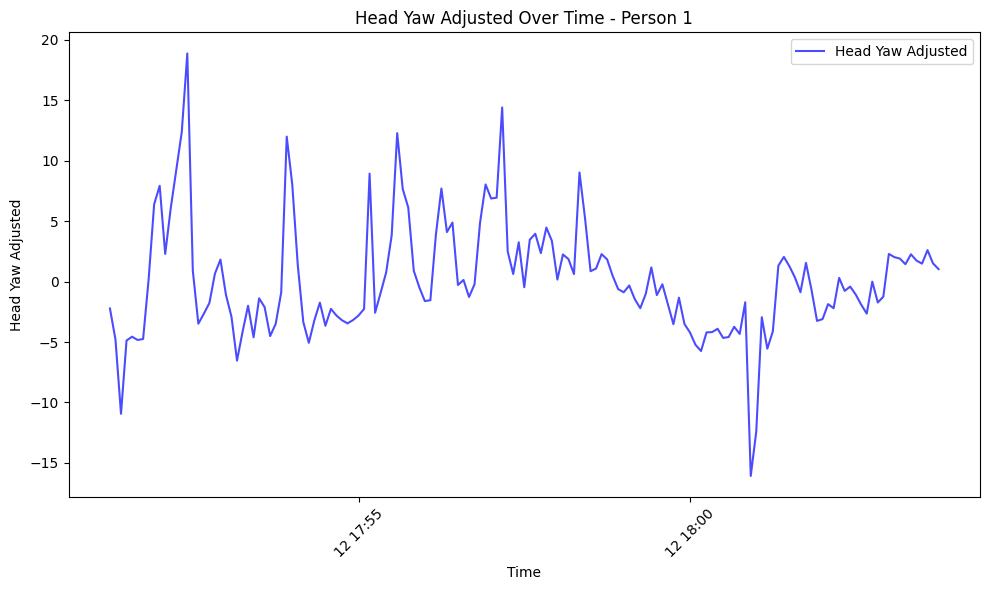

In [34]:
data_graphic = data.copy()
data_graphic.set_index('datetime', inplace=True)
persons = data_graphic['person'].unique()

for person in persons:
    data_person = data_graphic[data_graphic['person'] == person]
    grouped_data = data_person['head_yaw_adjusted'].resample(time_adjust).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data.index, grouped_data.values, color='blue', label='Head Yaw Adjusted', alpha=0.7)
    plt.title(f'Head Yaw Adjusted Over Time - Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Head Yaw Adjusted')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



## Variation in facial movement for each person

In [35]:
## First need to normalize the face area
data['face_area_Normalized'] = data['face_area'] / data['face_area'].max()

# Distance relative to the face area
data['relative_distance'] = 1 / np.sqrt(data['face_area']) * 1000

In [36]:
person1 = data['person'].unique()

# Calculate de distance between lines
# X_Distance / (Face_Area / Face_MaxArea) = X_Disatnce / Face_Area_Normalized

for i in person1:
    data_person_i = data[data['person'] == i]

    data.loc[data_person_i.index, 'head_movement_x_abs'] = (data_person_i['face_center_x'].diff().bfill() / data_person_i['face_area_Normalized']).abs()

    data.loc[data_person_i.index, 'head_movement_y_abs'] = (data_person_i['face_center_y'].diff().bfill() / data_person_i['face_area_Normalized']).abs()

    data.loc[data_person_i.index, 'head_movement_z_abs'] = data_person_i['relative_distance'].diff().bfill().abs()

### Check Data

In [37]:
print("_________________________")
print(data['head_movement_x_abs'].describe())
print("_________________________")
print(data['head_movement_y_abs'].describe())
print("_________________________")
print(data['head_movement_z_abs'].describe())
print("_________________________")

_________________________
count    13709.000000
mean         6.603793
std         13.616805
min          0.000000
25%          0.000000
50%          2.351753
75%          7.209598
max        282.023645
Name: head_movement_x_abs, dtype: float64
_________________________
count    13709.000000
mean         4.244472
std          7.596910
min          0.000000
25%          0.000000
50%          2.053388
75%          4.834158
max        134.984252
Name: head_movement_y_abs, dtype: float64
_________________________
count    13709.000000
mean         0.124145
std          0.193184
min          0.000000
25%          0.019929
50%          0.066411
75%          0.151597
max          4.019435
Name: head_movement_z_abs, dtype: float64
_________________________


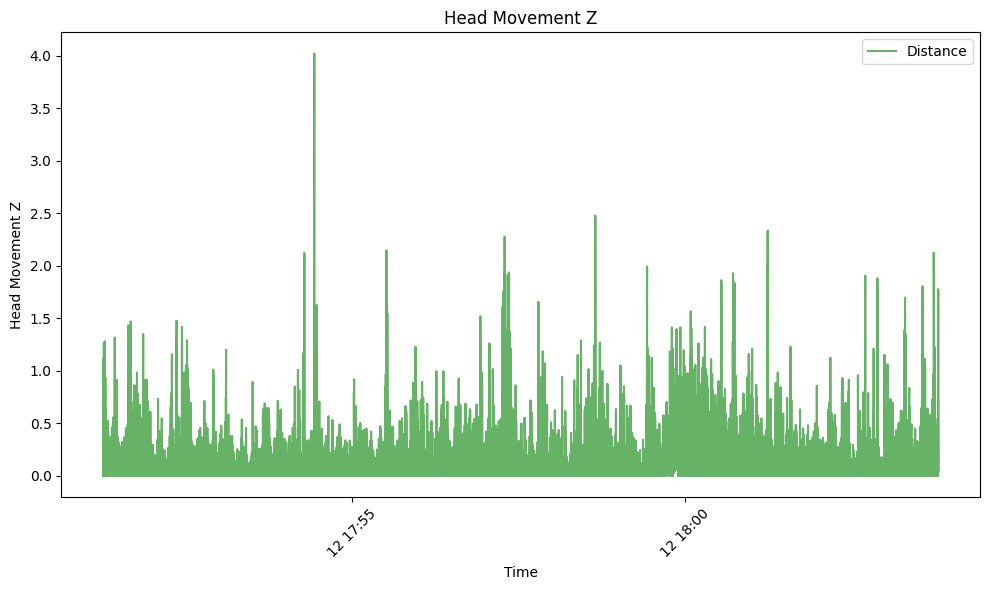

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['head_movement_z_abs'], color='green', label='Distance', alpha=0.6)

plt.title(f'Head Movement Z')
plt.xlabel('Time')
plt.ylabel('Head Movement Z')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Outliers

In [39]:
person1 = data['person'].unique()
print(data.shape)


for i in person1:
    data_person_i = data[data['person'] == i]
    columns_to_check = ['head_movement_x_abs', 'head_movement_y_abs', 'head_movement_z_abs']

    for column in columns_to_check:
        

        lower_bound = data[column].quantile(0.001)
        upper_bound = data[column].quantile(0.999)
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

(13709, 40)


In [40]:
print(data.shape)

(13541, 40)


#### Check Data

In [41]:
print("_________________________")
print(data['head_movement_x_abs'].describe())
print("_________________________")
print(data['head_movement_y_abs'].describe())
print("_________________________")
print(data['head_movement_z_abs'].describe())
print("_________________________")

_________________________
count    13541.000000
mean         5.876636
std          9.531947
min          0.000000
25%          0.000000
50%          2.292254
75%          6.945601
max         86.961039
Name: head_movement_x_abs, dtype: float64
_________________________
count    13541.000000
mean         3.823251
std          5.748210
min          0.000000
25%          0.000000
50%          2.026634
75%          4.671007
max         47.434183
Name: head_movement_y_abs, dtype: float64
_________________________
count    13541.000000
mean         0.113369
std          0.151282
min          0.000000
25%          0.017019
50%          0.064339
75%          0.147255
max          1.158712
Name: head_movement_z_abs, dtype: float64
_________________________


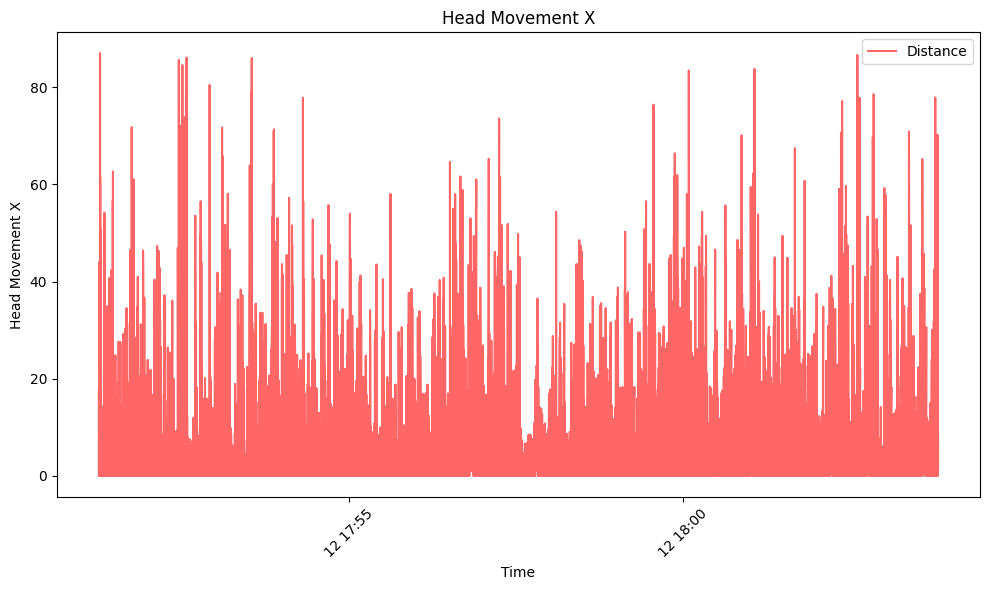

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['head_movement_x_abs'], color='red', label='Distance', alpha=0.6)

plt.title(f'Head Movement X')
plt.xlabel('Time')
plt.ylabel('Head Movement X')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Group in intervals

In [43]:
person1 = data['person'].unique()

for i in person1:
    data_person_i = data[data['person'] == i]
    columns_to_group = ['head_movement_x_abs', 'head_movement_y_abs', 'head_movement_z_abs']

    for column in columns_to_group:
        data_person_grouped = data_person_i.groupby(pd.Grouper(key='datetime', freq=time_adjust))[column].mean().reset_index()
        data_person_grouped.columns = ['datetime', f'{column}_{time_adjust}']

        for j in data_person_grouped.values:
            start_time = j[0]
            time_delta = pd.to_timedelta(time_adjust)
            end_time = start_time + time_delta
            mask = (data['datetime'] >= start_time) & (data['datetime'] < end_time) & (data['person'] == i)
            data.loc[mask, f'{column}_{time_adjust}'] = j[1]

In [44]:
data['head_movement_x_abs'].describe()

count    13541.000000
mean         5.876636
std          9.531947
min          0.000000
25%          0.000000
50%          2.292254
75%          6.945601
max         86.961039
Name: head_movement_x_abs, dtype: float64

In [45]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'head_yaw', 'head_pitch', 'head_roll',
       'left_eye_state', 'right_eye_state', 'left_eye_state_confidence',
       'right_eye_state_confidence', 'gaze_yaw', 'gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'time_block', 'gaze_pitch_mean',
       'gaze_yaw_mean', 'head_pitch_mean', 'head_yaw_mean', 'head_roll_mean',
       'gaze_pitch_adjusted', 'gaze_yaw_adjusted', 'head_pitch_adjusted',
       'head_yaw_adjusted', 'head_roll_adjusted', 'face_area_Normalized',
       'relative_distance', 'head_movement_x_abs', 'head_movement_y_abs',
       'head_movement_z_abs', 'head_movement_x_abs_5s',
       'head_movement_y_abs_5s', 'head_movement_z_abs_5s'],
      dtype='object')

In [46]:
print("_________________________")
print(data['head_movement_x_abs_5s'].describe())
print("_________________________")
print(data['head_movement_y_abs_5s'].describe())
print("_________________________")
print(data['head_movement_z_abs_5s'].describe())
print("_________________________")

_________________________
count    13541.000000
mean         5.876636
std          5.234483
min          0.000000
25%          1.778408
50%          4.510970
75%          8.451969
max         30.199722
Name: head_movement_x_abs_5s, dtype: float64
_________________________
count    13541.000000
mean         3.823251
std          3.102262
min          0.000000
25%          1.577075
50%          3.002886
75%          5.161341
max         20.773157
Name: head_movement_y_abs_5s, dtype: float64
_________________________
count    13541.000000
mean         0.113369
std          0.083837
min          0.008279
25%          0.055106
50%          0.090812
75%          0.150182
max          0.482455
Name: head_movement_z_abs_5s, dtype: float64
_________________________


## Difference between Gaze and Head Position

In [47]:
data['head_gaze_diff_yaw_abs'] = (data['head_yaw_adjusted'] - data['gaze_yaw_adjusted']).abs()
data['head_gaze_diff_pitch_abs'] = (data['head_pitch_adjusted'] - data['gaze_pitch_adjusted']).abs()

## Engagement

### Normalize Data

In [48]:
dataNormalized = pd.DataFrame()
# Difference between the head and gaze angles
dataNormalized['head_gaze_diff_yaw_abs_Normalized'] = data['head_gaze_diff_yaw_abs']/data['head_gaze_diff_yaw_abs'].max()
dataNormalized['head_gaze_diff_pitch_abs_Normalized'] = data['head_gaze_diff_pitch_abs']/data['head_gaze_diff_pitch_abs'].max()

# Normalize the values of head angles
dataNormalized['head_pitch_abs_Normalized'] = data['head_pitch_adjusted'].abs()/data['head_pitch_adjusted'].abs().max()
dataNormalized['head_yaw_abs_Normalized'] = data['head_yaw_adjusted'].abs()/data['head_yaw_adjusted'].abs().max()
dataNormalized['head_roll_abs_Normalized'] = data['head_roll_adjusted'].abs()/data['head_roll_adjusted'].abs().max()

# Normalize the values of gaze angles
dataNormalized['gaze_pitch_abs_Normalized'] = data['gaze_pitch_adjusted'].abs()/data['gaze_pitch_adjusted'].abs().max()
dataNormalized['gaze_yaw_abs_Normalized'] = data['gaze_yaw_adjusted'].abs()/data['gaze_yaw_adjusted'].abs().max()

# Normalize the movement of the head
dataNormalized['head_movement_x_Normalized'] = data['head_movement_x_abs']/data['head_movement_x_abs'].max()
dataNormalized['head_movement_x_abs_5s_Normalized'] = data['head_movement_x_abs_5s']/data['head_movement_x_abs_5s'].max()
dataNormalized['head_movement_y_Normalized'] = data['head_movement_y_abs']/data['head_movement_y_abs'].max()
dataNormalized['head_movement_y_abs_5s_Normalized'] = data['head_movement_y_abs_5s']/data['head_movement_y_abs_5s'].max()
dataNormalized['head_movement_z_Normalized'] = data['head_movement_z_abs']/data['head_movement_z_abs'].max()
dataNormalized['head_movement_z_abs_5s_Normalized'] = data['head_movement_z_abs_5s']/data['head_movement_z_abs_5s'].max()

In [49]:
gaze_yaw = dataNormalized['gaze_yaw_abs_Normalized']
gaze_pitch = dataNormalized['gaze_pitch_abs_Normalized']

gaze = (1 - (0.5 * gaze_pitch + 0.5 * gaze_yaw))

head_yaw = dataNormalized['head_yaw_abs_Normalized']
head_pitch = dataNormalized['head_pitch_abs_Normalized']
head_roll = dataNormalized['head_roll_abs_Normalized']

head = (1 - (0.333 * head_pitch + 0.333 * head_yaw + 0.333 * head_roll))

head_gaze_diff_yaw = dataNormalized['head_gaze_diff_yaw_abs_Normalized']
head_gaze_diff_pitch = dataNormalized['head_gaze_diff_pitch_abs_Normalized']

head_gaze_diff = (1 - (0.5 * head_gaze_diff_pitch + 0.5 * head_gaze_diff_yaw))

head_movement_x = dataNormalized['head_movement_x_Normalized']
head_movement_x_5s = dataNormalized['head_movement_x_abs_5s_Normalized']
head_movement_y = dataNormalized['head_movement_y_Normalized']
head_movement_y_5s = dataNormalized['head_movement_y_abs_5s_Normalized']
head_movement_z = dataNormalized['head_movement_z_Normalized']
head_movement_z_5s = dataNormalized['head_movement_z_abs_5s_Normalized']

head_movement = (1 - (0.333 * head_movement_x + 0.333 * head_movement_y + 0.333 * head_movement_z))
head_movement_5s = (1 - (0.333 * head_movement_x_5s + 0.333 * head_movement_y_5s + 0.333 * head_movement_z_5s))


data['engagement0'] = 0.333 * head + 0.333 * gaze + 0.333 * head_movement_5s
data['engagement1'] = 0.25 * head + 0.25 * gaze + 0.25 * head_gaze_diff + 0.25 * head_movement_5s
data['engagement2'] = 0.25 * (1 - head_yaw) + 0.25 * (1 - gaze_yaw) + 0.25 * (1 - head_roll) + 0.25 * head_gaze_diff
data['engagement3'] = 0.20 * head + 0.20 * gaze + 0.20 * head_gaze_diff + 0.20 * head_movement_5s + 0.20 * (1 - head_yaw)
data['engagement4'] = 0.25 * (1 - head_pitch) + 0.25 * (1 - gaze_pitch) + 0.25 * (1 - head_roll) + 0.25 * head_gaze_diff
data['engagement5'] = head_movement_5s
data['engagement6'] = head
data['engagement7'] = gaze
data['engagement8'] = head_gaze_diff
data['engagement9'] = head_movement

# adicionar ao dicionário de dados se é uma variável para offline ou online ou ambos (group_diff é variável offline)
# colocar outra coluna para justificar o porquê de ser online ou offline apenas
# Fazer a tabela por ordem as maiores correlações em relação a cada variável de engagement

person
0    0.739654
1    0.806439
2    0.751219
3    0.876240
Name: engagement0, dtype: float64


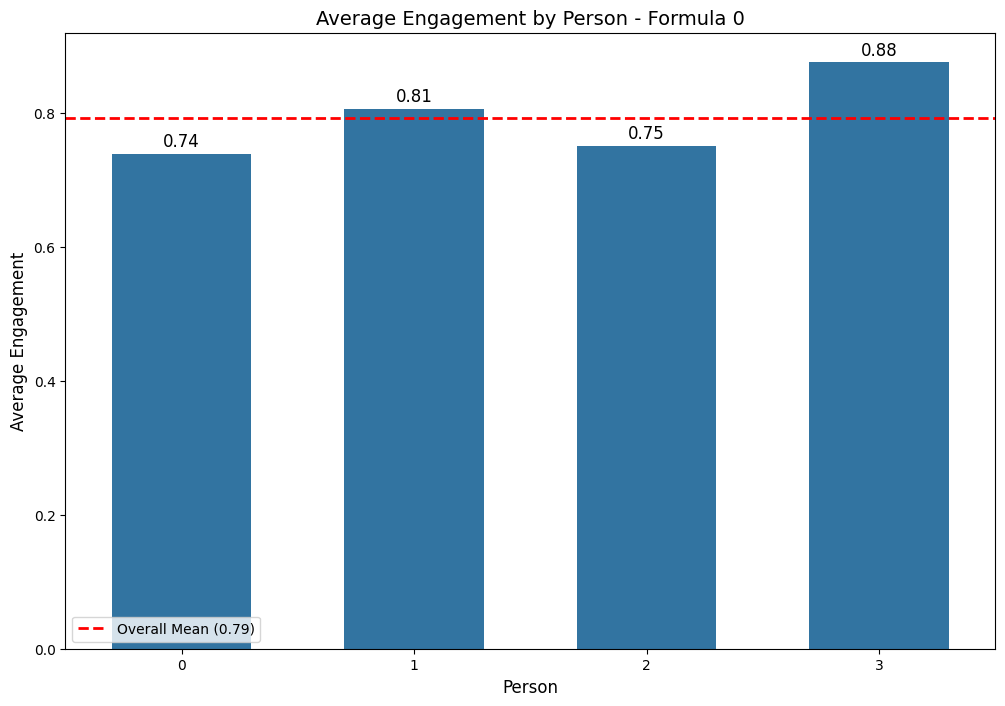

person
0    0.730418
1    0.796946
2    0.760003
3    0.868057
Name: engagement1, dtype: float64


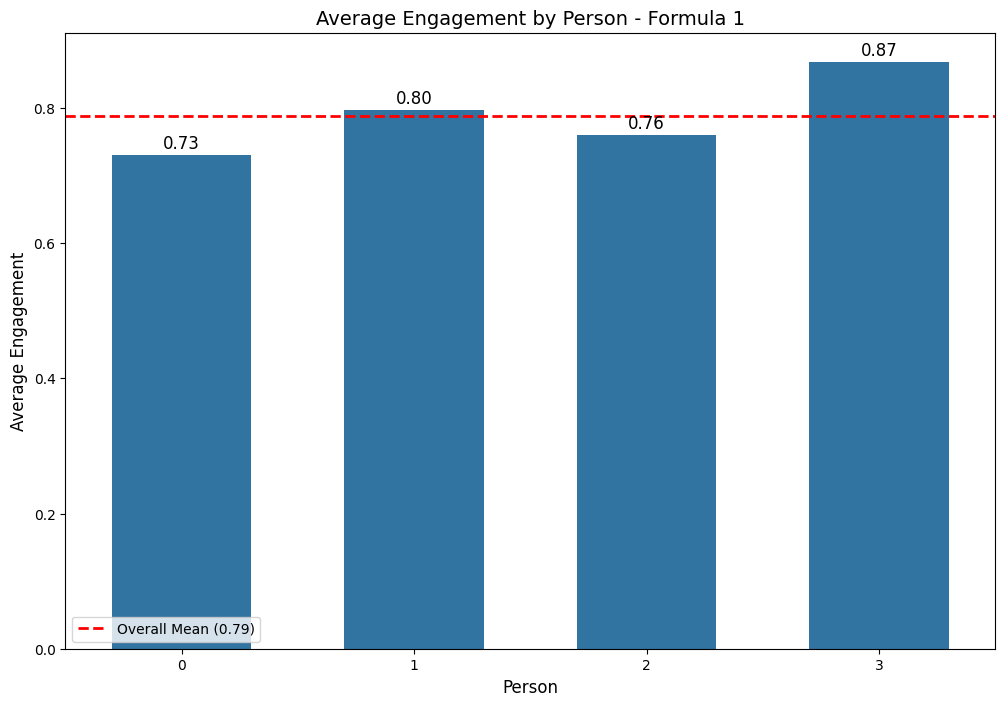

person
0    0.737724
1    0.842964
2    0.776165
3    0.865142
Name: engagement2, dtype: float64


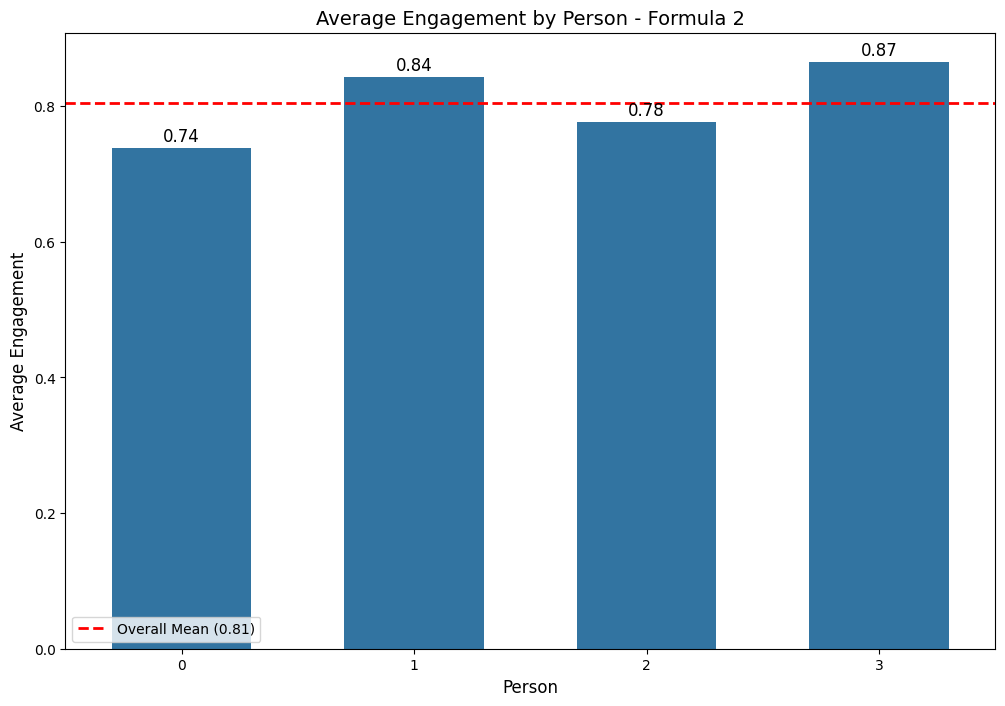

person
0    0.714427
1    0.813830
2    0.744801
3    0.872009
Name: engagement3, dtype: float64


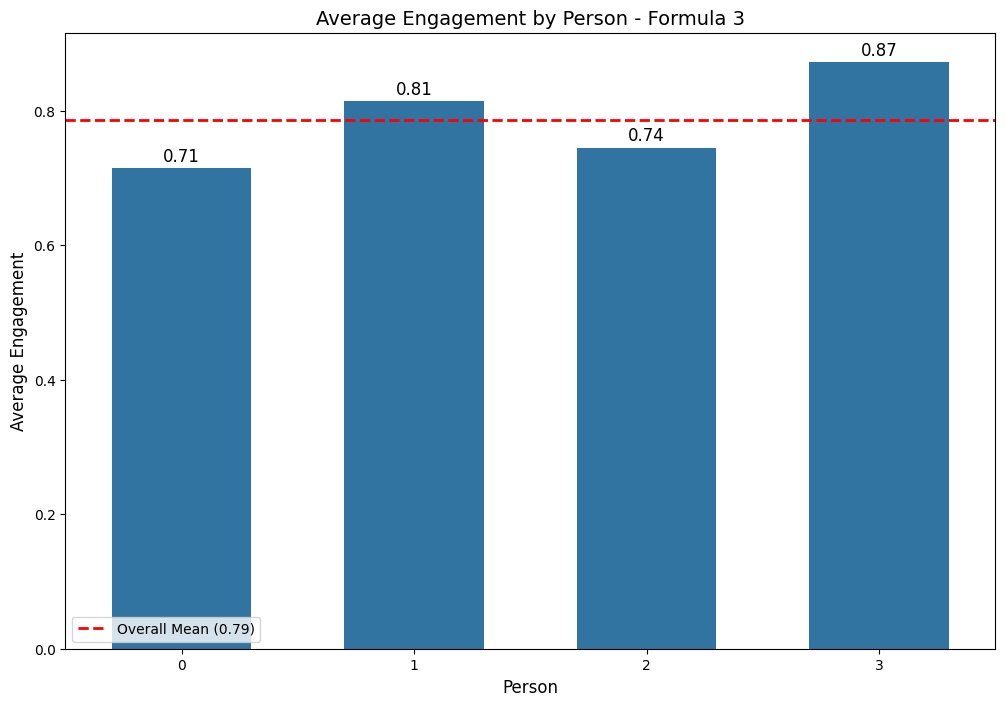

person
0    0.721880
1    0.772350
2    0.781852
3    0.879568
Name: engagement4, dtype: float64


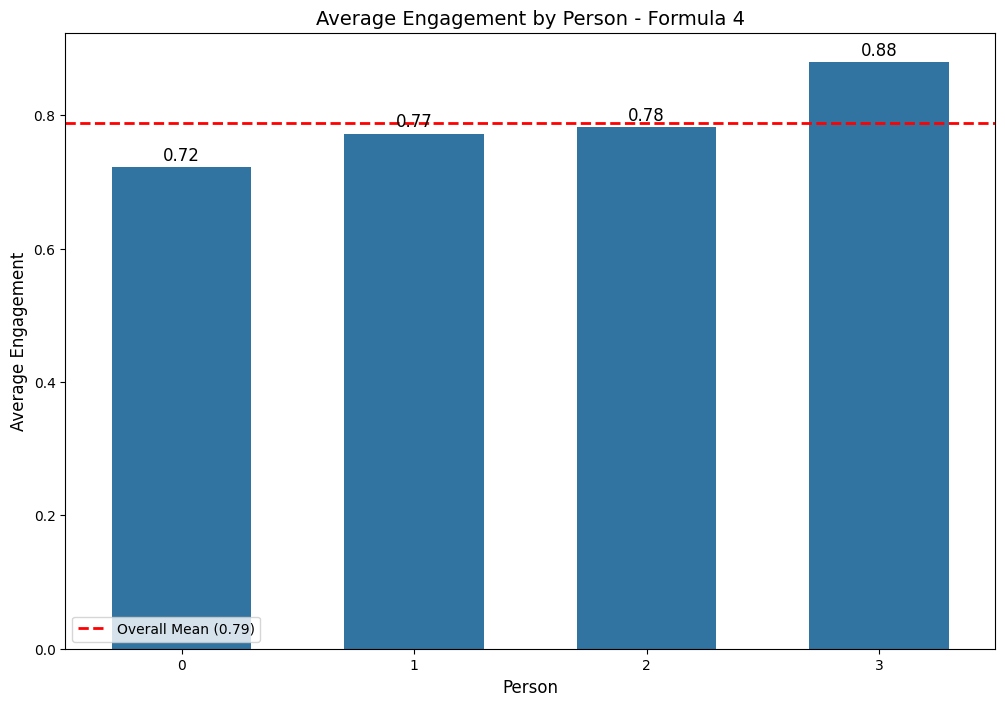

person
0    0.751232
1    0.779698
2    0.755499
3    0.893806
Name: engagement5, dtype: float64


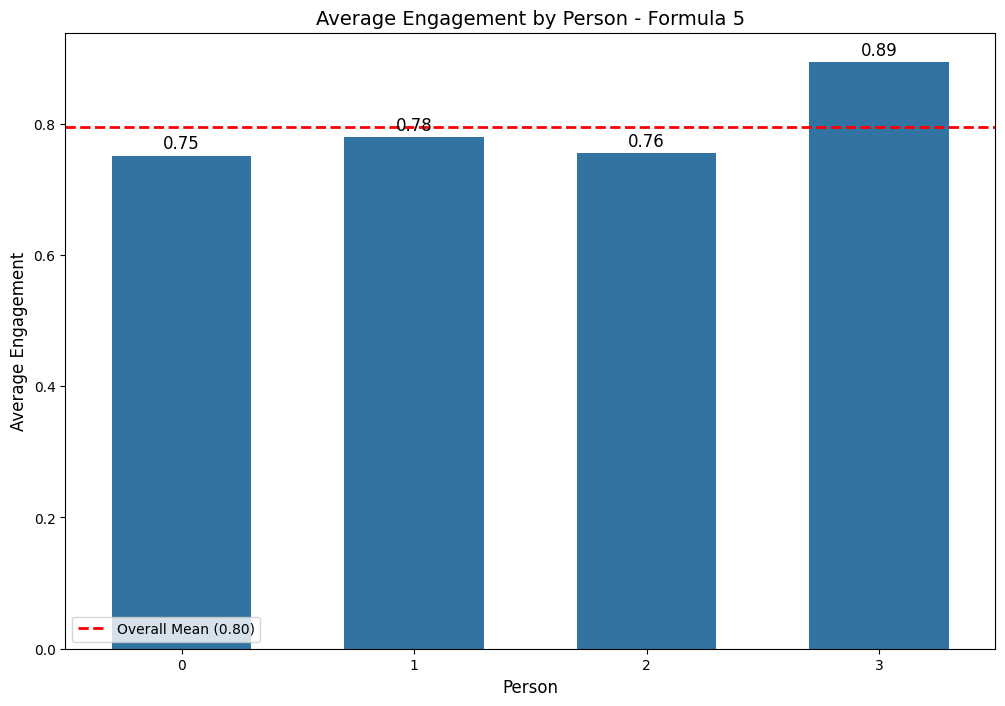

person
0    0.718238
1    0.803670
2    0.763435
3    0.902544
Name: engagement6, dtype: float64


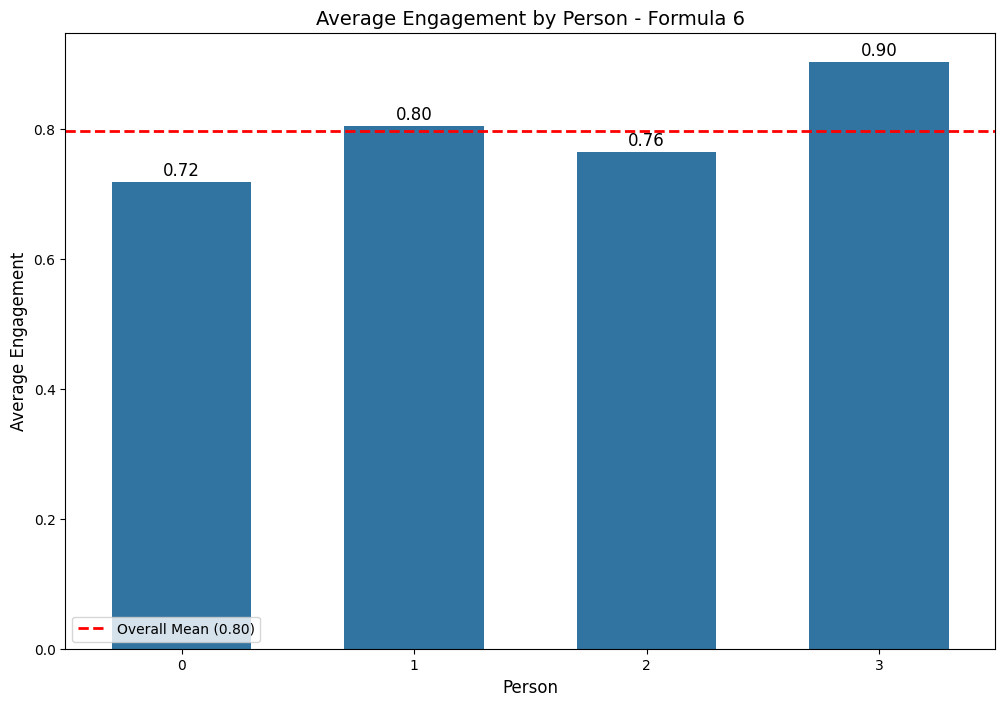

person
0    0.751714
1    0.838369
2    0.736980
3    0.835002
Name: engagement7, dtype: float64


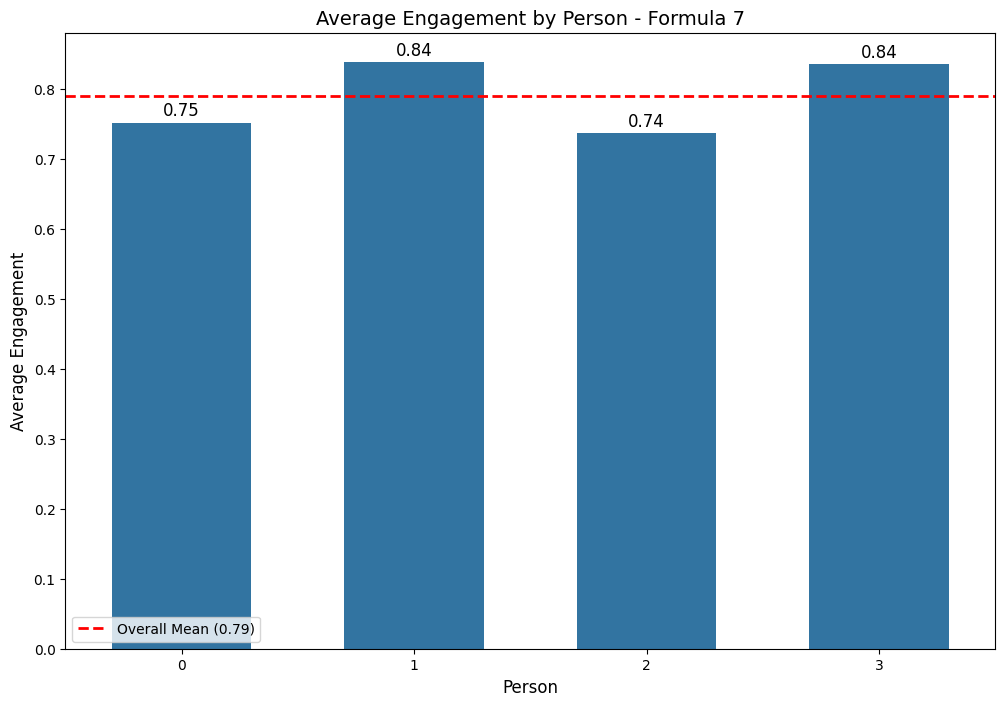

person
0    0.700487
1    0.766046
2    0.784099
3    0.840878
Name: engagement8, dtype: float64


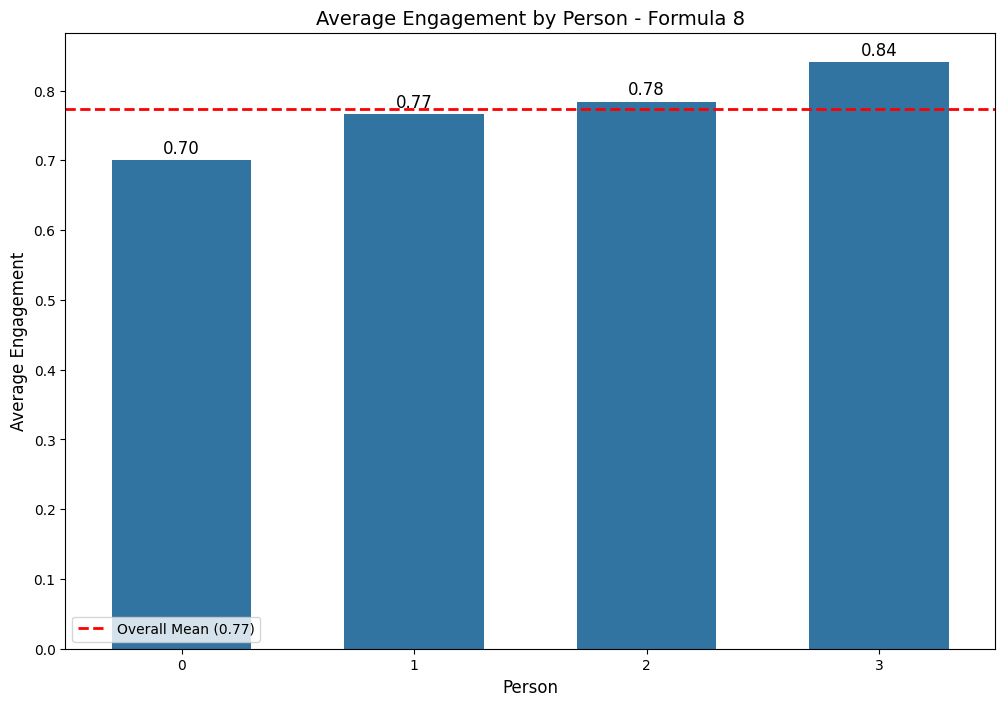

person
0    0.899373
1    0.910314
2    0.903926
3    0.957670
Name: engagement9, dtype: float64


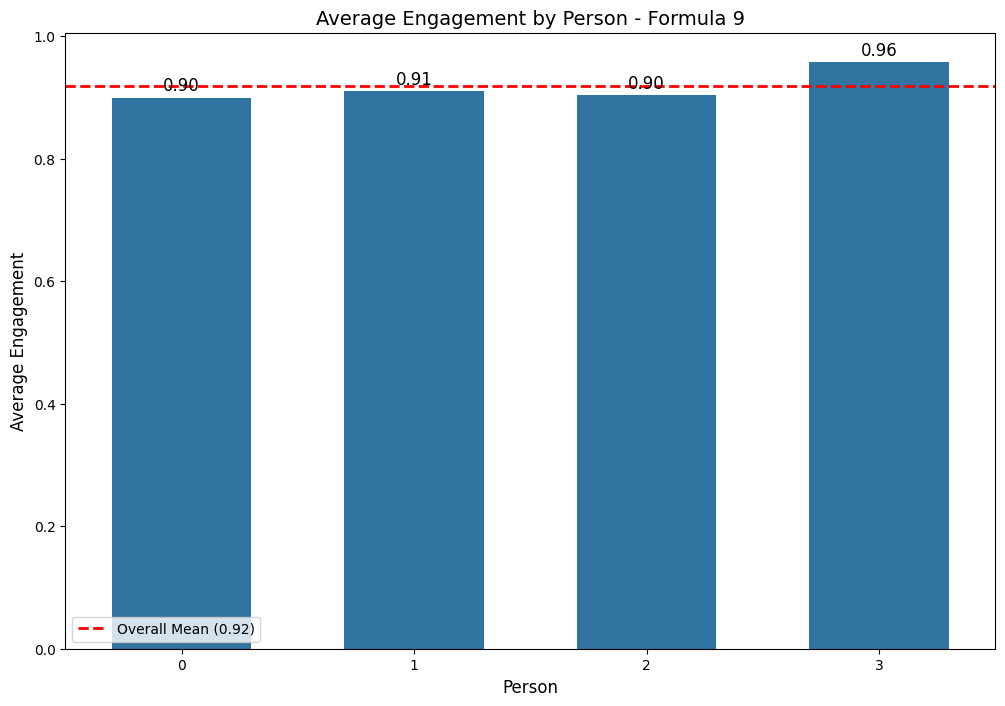

In [50]:
i = 0

while i < 10:
    formula = f'engagement{i}'
    group_cluster_engagment = data.groupby(['person'])
    print(group_cluster_engagment[formula].mean())

    engagement_means = data.groupby('person')[formula].mean().reset_index()

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        x='person', 
        y=formula, 
        data=engagement_means,
        width=0.6,
    )

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}',  
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='baseline', 
                        fontsize=12,
                        xytext=(0, 5), 
                        textcoords='offset points')

    overall_mean = engagement_means[formula].mean()
    plt.axhline(overall_mean, color='red', linestyle='--', linewidth=2, label=f'Overall Mean ({overall_mean:.2f})')

    plt.title(f'Average Engagement by Person - Formula {i}', fontsize=14)
    plt.xlabel('Person', fontsize=12)
    plt.ylabel('Average Engagement', fontsize=12)
    plt.legend(title='', loc='lower left')
    
    # # Salvar o gráfico na pasta atual
    # filename = f'{formula}_5s.png'
    # plt.tight_layout()
    # plt.savefig(filename)
    # print(f'Gráfico salvo como: {filename}')
    
    plt.show()
    i += 1


## Correlation Matrix

In [51]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'head_yaw', 'head_pitch', 'head_roll',
       'left_eye_state', 'right_eye_state', 'left_eye_state_confidence',
       'right_eye_state_confidence', 'gaze_yaw', 'gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'time_block', 'gaze_pitch_mean',
       'gaze_yaw_mean', 'head_pitch_mean', 'head_yaw_mean', 'head_roll_mean',
       'gaze_pitch_adjusted', 'gaze_yaw_adjusted', 'head_pitch_adjusted',
       'head_yaw_adjusted', 'head_roll_adjusted', 'face_area_Normalized',
       'relative_distance', 'head_movement_x_abs', 'head_movement_y_abs',
       'head_movement_z_abs', 'head_movement_x_abs_5s',
       'head_movement_y_abs_5s', 'head_movement_z_abs_5s',
       'head_gaze_diff_yaw_abs', 'head_gaze_diff_pitch_abs', 'engagement0',
       'engagement1', 'engagement2', 'engagement3', 'engagement4',
       'e

### Values

In [52]:
data_dicts = {
    'Head Pitch': data.groupby(['person'])['head_pitch_adjusted'].mean().to_dict(),
    'Head Yaw': data.groupby(['person'])['head_yaw_adjusted'].mean().to_dict(),
    'Head Roll': data.groupby(['person'])['head_roll_adjusted'].mean().to_dict(),
    'Gaze Pitch': data.groupby(['person'])['gaze_pitch_adjusted'].mean().to_dict(),
    'Gaze Yaw': data.groupby(['person'])['gaze_yaw_adjusted'].mean().to_dict(),
    'Face Area': data.groupby(['person'])['face_area_Normalized'].mean().to_dict(),
    'Relative Distance': data.groupby(['person'])['relative_distance'].mean().to_dict(),
    'Head Gaze Diff Yaw': data.groupby(['person'])['head_gaze_diff_yaw_abs'].mean().to_dict(),
    'Head Gaze Diff Pitch': data.groupby(['person'])['head_gaze_diff_pitch_abs'].mean().to_dict(),
    'Head Movement X': data.groupby(['person'])['head_movement_x_abs_5s'].mean().to_dict(),
    'Head Movement Y': data.groupby(['person'])['head_movement_y_abs_5s'].mean().to_dict(),
    'Head Movement Z': data.groupby(['person'])['head_movement_z_abs_5s'].mean().to_dict(),
    'Engagement 0': data.groupby(['person'])['engagement0'].mean().to_dict(),
    'Engagement 1': data.groupby(['person'])['engagement1'].mean().to_dict(),
    'Engagement 2': data.groupby(['person'])['engagement2'].mean().to_dict(),
    'Engagement 3': data.groupby(['person'])['engagement3'].mean().to_dict(),
    'Engagement 4': data.groupby(['person'])['engagement4'].mean().to_dict(),
    'Engagement 5': data.groupby(['person'])['engagement5'].mean().to_dict(),
    'Engagement 6': data.groupby(['person'])['engagement6'].mean().to_dict(),
    'Engagement 7': data.groupby(['person'])['engagement7'].mean().to_dict(),
    'Engagement 8': data.groupby(['person'])['engagement8'].mean().to_dict(),
    'Engagement 9': data.groupby(['person'])['engagement9'].mean().to_dict(),
}

### Matrix

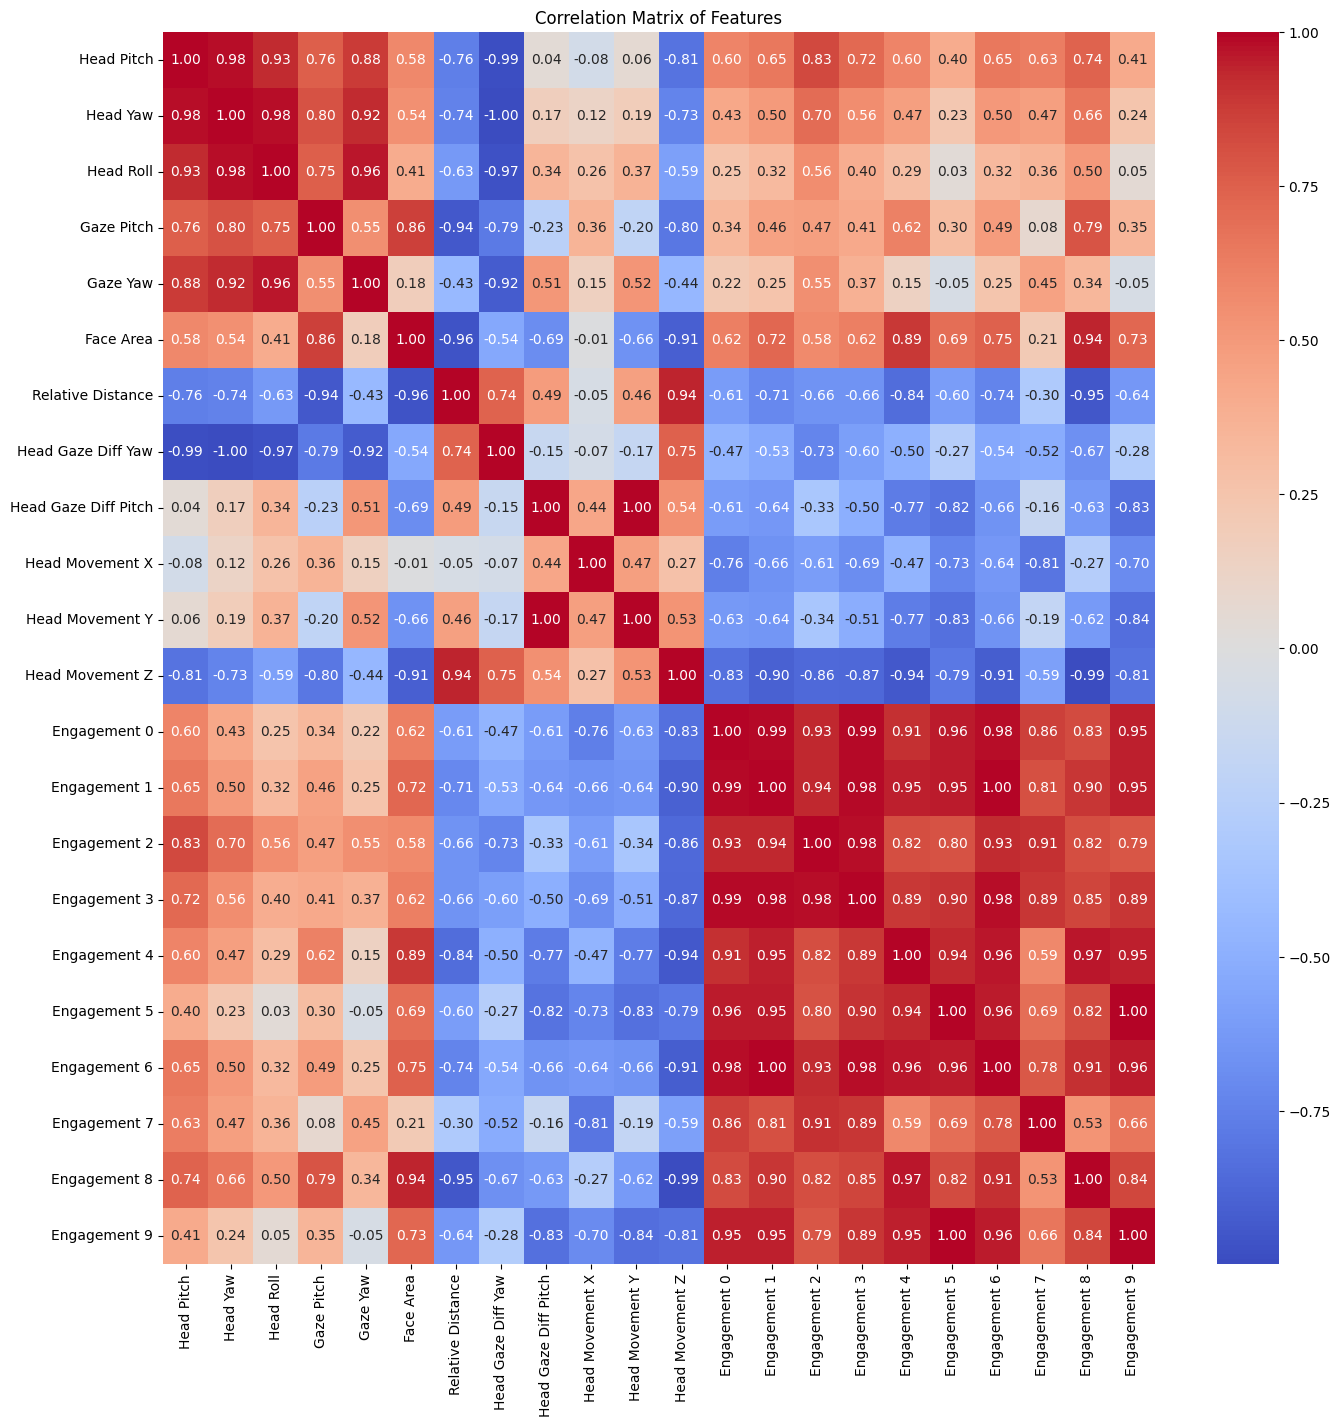

Engagement 0


,Feature,Correlation with Engagement
0,Engagement 0,1.000000
1,Engagement 1,0.990588
2,Engagement 3,0.987029
3,Engagement 6,0.983770
4,Engagement 5,0.956102
5,Engagement 9,0.947118
6,Engagement 2,0.933905
7,Engagement 4,0.906431
8,Engagement 7,0.860569
9,Engagement 8,0.826944


Engagement 1


,Feature,Correlation with Engagement
0,Engagement 1,1.000000
1,Engagement 6,0.998916
2,Engagement 0,0.990588
3,Engagement 3,0.984983
4,Engagement 5,0.954521
5,Engagement 9,0.952725
6,Engagement 4,0.950615
7,Engagement 2,0.936564
8,Engagement 8,0.896126
9,Engagement 7,0.807481


Engagement 2


,Feature,Correlation with Engagement
0,Engagement 2,1.000000
1,Engagement 3,0.978903
2,Engagement 1,0.936564
3,Engagement 0,0.933905
4,Engagement 6,0.926655
5,Engagement 7,0.911451
6,Head Pitch,0.828729
7,Engagement 8,0.819317
8,Engagement 4,0.818464
9,Engagement 5,0.797341


Engagement 3


,Feature,Correlation with Engagement
0,Engagement 3,1.000000
1,Engagement 0,0.987029
2,Engagement 1,0.984983
3,Engagement 2,0.978903
4,Engagement 6,0.977391
5,Engagement 5,0.902920
6,Engagement 9,0.894546
7,Engagement 7,0.890988
8,Engagement 4,0.888776
9,Engagement 8,0.845976


Engagement 4


,Feature,Correlation with Engagement
0,Engagement 4,1.000000
1,Engagement 8,0.966117
2,Engagement 6,0.963881
3,Engagement 9,0.951863
4,Engagement 1,0.950615
5,Engagement 5,0.937444
6,Engagement 0,0.906431
7,Engagement 3,0.888776
8,Face Area,0.888275
9,Engagement 2,0.818464


Engagement 5


,Feature,Correlation with Engagement
0,Engagement 5,1.000000
1,Engagement 9,0.998503
2,Engagement 0,0.956102
3,Engagement 6,0.956052
4,Engagement 1,0.954521
5,Engagement 4,0.937444
6,Engagement 3,0.902920
7,Engagement 8,0.821117
8,Engagement 2,0.797341
9,Engagement 7,0.692926


Engagement 6


,Feature,Correlation with Engagement
0,Engagement 6,1.000000
1,Engagement 1,0.998916
2,Engagement 0,0.983770
3,Engagement 3,0.977391
4,Engagement 4,0.963881
5,Engagement 9,0.956766
6,Engagement 5,0.956052
7,Engagement 2,0.926655
8,Engagement 8,0.913777
9,Engagement 7,0.780158


Engagement 7


,Feature,Correlation with Engagement
0,Engagement 7,1.000000
1,Engagement 2,0.911451
2,Engagement 3,0.890988
3,Engagement 0,0.860569
4,Engagement 1,0.807481
5,Engagement 6,0.780158
6,Engagement 5,0.692926
7,Engagement 9,0.662355
8,Head Pitch,0.631841
9,Engagement 4,0.586004


Engagement 8


,Feature,Correlation with Engagement
0,Engagement 8,1.000000
1,Engagement 4,0.966117
2,Face Area,0.941309
3,Engagement 6,0.913777
4,Engagement 1,0.896126
5,Engagement 3,0.845976
6,Engagement 9,0.842867
7,Engagement 0,0.826944
8,Engagement 5,0.821117
9,Engagement 2,0.819317


Engagement 9


,Feature,Correlation with Engagement
0,Engagement 9,1.000000
1,Engagement 5,0.998503
2,Engagement 6,0.956766
3,Engagement 1,0.952725
4,Engagement 4,0.951863
5,Engagement 0,0.947118
6,Engagement 3,0.894546
7,Engagement 8,0.842867
8,Engagement 2,0.788125
9,Face Area,0.725362


In [53]:
df = pd.DataFrame(data_dicts)

plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()


for i in range(10):
    print(f'Engagement {i}')
    correlation_table = df.corr()[f'Engagement {i}'].sort_values(ascending=False)
    table = correlation_table.reset_index()
    table.columns = ['Feature', 'Correlation with Engagement']
    display(table)

In [54]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'head_yaw', 'head_pitch', 'head_roll',
       'left_eye_state', 'right_eye_state', 'left_eye_state_confidence',
       'right_eye_state_confidence', 'gaze_yaw', 'gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'time_block', 'gaze_pitch_mean',
       'gaze_yaw_mean', 'head_pitch_mean', 'head_yaw_mean', 'head_roll_mean',
       'gaze_pitch_adjusted', 'gaze_yaw_adjusted', 'head_pitch_adjusted',
       'head_yaw_adjusted', 'head_roll_adjusted', 'face_area_Normalized',
       'relative_distance', 'head_movement_x_abs', 'head_movement_y_abs',
       'head_movement_z_abs', 'head_movement_x_abs_5s',
       'head_movement_y_abs_5s', 'head_movement_z_abs_5s',
       'head_gaze_diff_yaw_abs', 'head_gaze_diff_pitch_abs', 'engagement0',
       'engagement1', 'engagement2', 'engagement3', 'engagement4',
       'e

In [55]:
data.dtypes

datetime                      datetime64[ns]
source                                object
face                                   int64
face_bbox_x1                           int64
face_bbox_y1                           int64
face_bbox_x2                           int64
face_bbox_y2                           int64
head_yaw                             float64
head_pitch                           float64
head_roll                            float64
left_eye_state                        object
right_eye_state                       object
left_eye_state_confidence            float64
right_eye_state_confidence           float64
gaze_yaw                             float64
gaze_pitch                           float64
facial_expression                     object
race                                  object
gender                                object
age                                    int64
face_center_x                        float64
face_center_y                        float64
face_area 

## Create Final Dataset

In [56]:
data.to_csv('online_new.csv', index=False)